In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2@family=JetBrains+Mono:wght@300@display=swap');
* {
    font-family: 'JetBrains Mono', monospace;
}
</style>

# Setup
`python3 -m pip install pyreadr, numpy, pandas, matplotlib, seaborn, scipy, imbalanced-learn, scikit-learn, shap`

In [2]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import imblearn
from sklearn.preprocessing import LabelEncoder

*rdata* is a file format used for the **R** language. To read the data contained, we need to use the `pyreadr` package.

In [3]:
data_file = '../5v_cleandf.rdata'
r_format = pyreadr.read_r(data_file)
df = r_format['df']  # df is the dataset contained in the file
df.head().T

,0,1,2,3,4
dep_name,B,B,B,A,A
esi,4,4,2,2,3
age,40,66,66,66,84
gender,Male,Male,Male,Male,Female
ethnicity,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino
...,...,...,...,...,...
cc_woundcheck,0,0,0,0,0
cc_woundinfection,0,0,0,0,0
cc_woundre-evaluation,0,0,0,0,0
cc_wristinjury,0,0,0,0,0


The dataset is too large to work with fast, so we can condense it only to the columns that are related.

In [4]:
columns = ['esi',
           'age',
           'gender',
           'ethnicity',
           'race',
           'lang',
           'religion',
           'maritalstatus',
           'employstatus',
           'insurance_status',
           'disposition',
           'arrivalmode',
           'previousdispo']

data = df.copy()[columns] # new dataframe with the selected columns

The dataset contains many `null` values, so we can simply remove any rows that contain a `null` value in it.

In [5]:
cols_in_dataframe = list(data.columns)

for col in cols_in_dataframe:
    rows_to_remove = []
    nulled_col = list(data[col].isnull())
    for i in range(len(nulled_col)):
        if nulled_col[i] == True:
            rows_to_remove.append(i)
    rows_to_remove.sort(reverse=True)
    
    data.drop(rows_to_remove, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    print('Done condensing:', col)

Done condensing: esi
Done condensing: age
Done condensing: gender
Done condensing: ethnicity
Done condensing: race
Done condensing: lang
Done condensing: religion
Done condensing: maritalstatus
Done condensing: employstatus
Done condensing: insurance_status
Done condensing: disposition
Done condensing: arrivalmode
Done condensing: previousdispo


Label encoding makes the data easier for the model to work with. It takes the different values of a column and assigns an individual number to it.
<br />
Ex: `[a, b, a, a, c] => [0, 1, 0, 0, 2]`

In [6]:
%%capture
cont = ['esi', 'age']
cat = [
    'gender',
    'ethnicity',
    'race',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
    'previousdispo'
]

# Create individual label encoders for each column
transformers = {}
for col in cat:
    transformers[col] = LabelEncoder()

# fit each column with its corresponding label encoder
for col in cat:
    data[col] = data[[col]].apply(transformers[col].fit_transform)

The `esi` column is stored as strings, so we can convert the strings to numbers.

In [7]:
data['esi'] = data['esi'].astype(int)

Let's split the training and the testing data with the `sklearn` module.
We can split the large dataframe we have into **training** and **testing** dataframes with the `sklearn` module.
**Training** data is used to train the models, while **testing** data is used to test the accuracy of the model on data it hasn't seen before.

In [8]:
cols_to_train_on = [
    'esi', 'age', 'gender', 'ethnicity', 'race', 'lang', 'religion',
#     'maritalstatus', 'employstatus', 'insurance_status', 'disposition',
    'maritalstatus', 'employstatus', 'insurance_status',
    'arrivalmode'
]

# col_dep_var = [ 'previousdispo' ]
col_dep_var = [ 'disposition' ]

In [9]:
from sklearn.model_selection import train_test_split

`X` is going to be the dataframe with the columns that we want to train on.  
`y` is going to be the dataframe with the column of the dependent variable.

In [10]:
X = data[cols_to_train_on]
y = data[col_dep_var]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

The process above takes the two dataframes `X` and `y` which contain the <u>data the model will see</u> and the <u>data the model will try to predict</u>, respectively, and splits them into training and testing data with a ratio of **8:2**.

In [12]:
train = pd.DataFrame(X_train)
# train['previousdispo'] = y_train
train['disposition'] = y_train
train.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode,disposition
72403,3,49,0,1,7,0,1,4,1,0,4,1
523720,3,49,1,0,6,0,10,7,4,3,0,1
225701,4,37,0,1,7,0,8,7,1,0,6,1
314825,3,58,0,0,4,0,0,7,0,2,0,0
47228,3,74,1,1,7,0,1,4,5,0,0,0


In [13]:
test = pd.DataFrame(X_test)
# test['previousdispo'] = y_test
test['disposition'] = y_test
test.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode,disposition
125651,2,21,0,1,2,0,2,7,4,0,0,0
132800,4,71,0,1,7,0,1,4,4,0,0,1
120896,4,49,1,0,4,0,1,4,2,1,4,1
150527,2,84,0,1,2,0,10,9,5,2,0,1
168366,4,49,1,1,2,0,6,7,6,1,6,1


We consolidated the data back into `train` and `test` dataframes again, if we need the full dataframe for some reason.

In [14]:
# X_train = X_train.drop(columns='previousdispo')
X_train = X_train.drop(columns='disposition')
X_train.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode
72403,3,49,0,1,7,0,1,4,1,0,4
523720,3,49,1,0,6,0,10,7,4,3,0
225701,4,37,0,1,7,0,8,7,1,0,6
314825,3,58,0,0,4,0,0,7,0,2,0
47228,3,74,1,1,7,0,1,4,5,0,0


In [16]:
# X_test = X_test.drop(columns='previousdispo')
X_test = X_test.drop(columns='disposition')
X_test.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode
125651,2,21,0,1,2,0,2,7,4,0,0
132800,4,71,0,1,7,0,1,4,4,0,0
120896,4,49,1,0,4,0,1,4,2,1,4
150527,2,84,0,1,2,0,10,9,5,2,0
168366,4,49,1,1,2,0,6,7,6,1,6


### Implementing Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

brc = RandomForestClassifier(
    n_estimators=100,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

In [20]:
brc.fit(X_train, np.ravel(y_train)) # fit the classifier

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.6s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=2)

In [21]:
preds = brc.predict(X_test) # predict

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


In [22]:
brc.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


0.7610271875203604

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.62      0.57      0.59     33087
           1       0.82      0.85      0.83     74352

    accuracy                           0.76    107439
   macro avg       0.72      0.71      0.71    107439
weighted avg       0.76      0.76      0.76    107439



# SHAP Values

In [25]:
import shap

In [26]:
X_test['age'] = X_test['age'].astype('int')

Patrick's `shap` model implemented with the `Balanced Random Forest Classifier`

`Explainer` was changed to `TreeExplainer` because we are using a **RandomForest** classifier, and **TreeExplainer** should yield faster run-times.

In [27]:
explainer = shap.Explainer(brc)

There are **107439** samples in `X_test`, and `shap` is computationally expensive, so we can use the explainer to explain the first **50** samples in `X_test`.

In [28]:
shap_values = explainer.shap_values(X_test[:50])

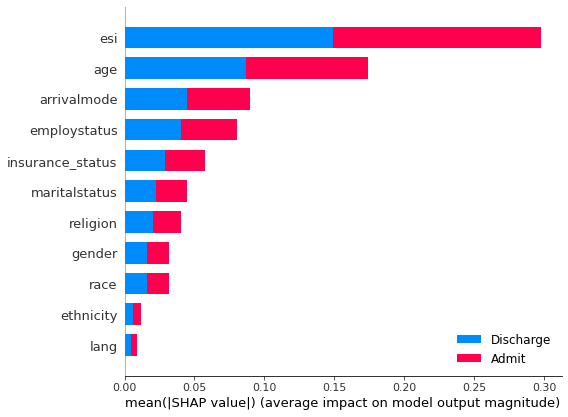

In [29]:
shap.summary_plot(
    shap_values,
    X_train.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_train.columns
)

In [30]:
shap.initjs()
i = 3
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_train.values[i], feature_names = X_train.columns)

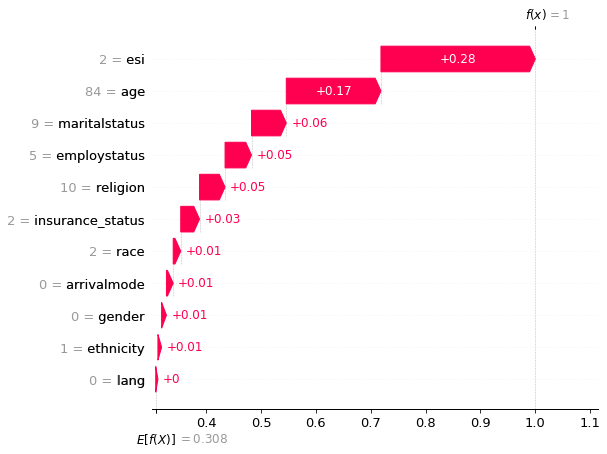

In [31]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)

In [32]:
transformers["gender"].inverse_transform([0, 1])

array(['Female', 'Male'], dtype=object)

In [33]:
fdata = X_test[X_test["gender"] == 0]
fdata.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode
125651,2,21,0,1,2,0,2,7,4,0,0
132800,4,71,0,1,7,0,1,4,4,0,0
150527,2,84,0,1,2,0,10,9,5,2,0
309156,3,18,0,1,7,0,12,7,2,0,0
392553,2,61,0,0,4,0,10,4,1,0,4


In [34]:
mdata = X_test[X_test["gender"] == 1]
mdata.head()

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,arrivalmode
120896,4,49,1,0,4,0,1,4,2,1,4
168366,4,49,1,1,2,0,6,7,6,1,6
101884,5,39,1,1,1,0,8,4,1,0,0
237567,2,73,1,1,7,0,3,9,5,2,6
231411,2,62,1,1,7,0,1,4,1,0,0


In [35]:
mdata = mdata.astype('int')
fdata = fdata.astype('int')

In [36]:
mshap_values = explainer.shap_values(mdata[:500])

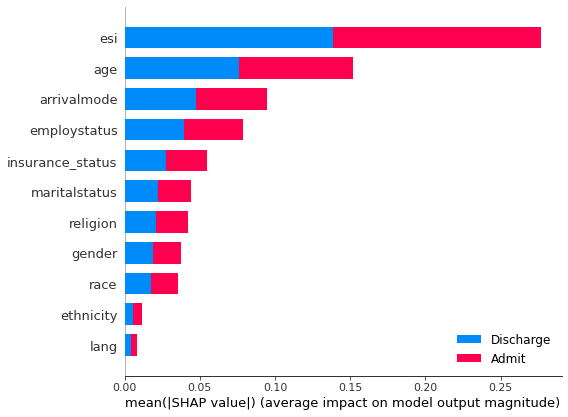

In [37]:
shap.summary_plot(
    mshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

#### male data

In [38]:
fshap_values = explainer.shap_values(fdata[:500])

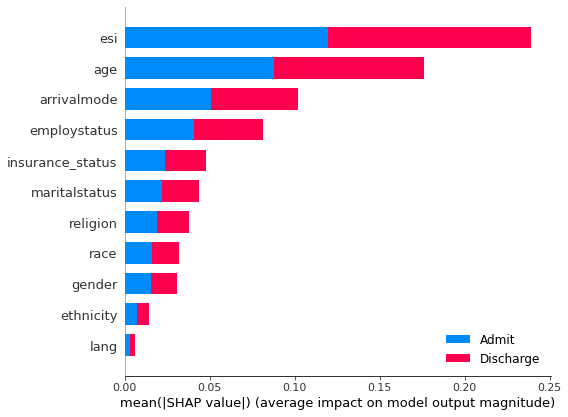

In [39]:
shap.summary_plot(
    fshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

#### female data

# Comparing Effects of Race on Triage for African Americans, Whites, and Asians

In [40]:
transformers["race"].inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])

array(['American Indian or Alaska Native', 'Asian',
       'Black or African American',
       'Native Hawaiian or Other Pacific Islander', 'Other',
       'Patient Refused', 'Unknown', 'White or Caucasian'], dtype=object)

In [41]:
African_DData = X_test[X_test["race"] == 3]
White_DData = X_test[X_test["race"] == 7]
Asian_DData = X_test[X_test["race"] == 2]

In [42]:
AfricanAshap_values = explainer.shap_values(African_DData[:500])

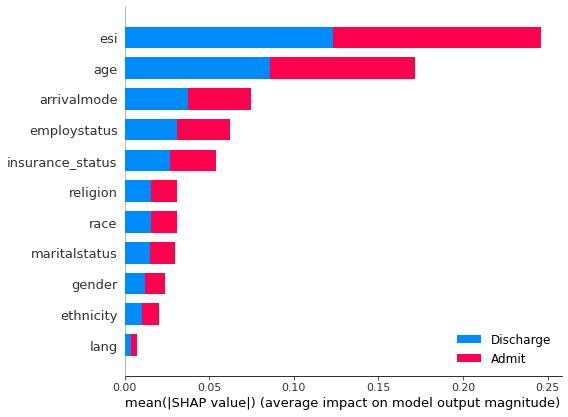

In [43]:
shap.summary_plot(
    AfricanAshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

#### African American data

In [44]:
Whiteshap_values = explainer.shap_values(White_DData[:500])

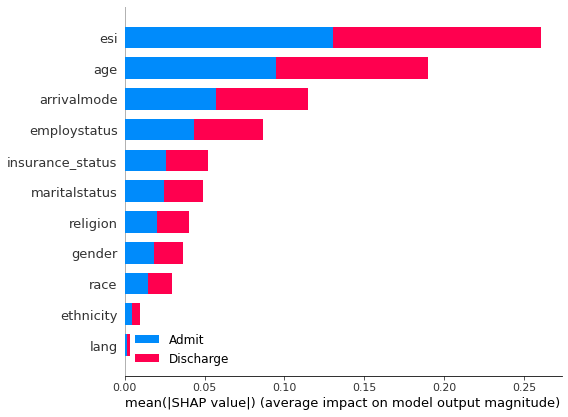

In [45]:
shap.summary_plot(
    Whiteshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

#### White Data

In [46]:
AsianAshap_values = explainer.shap_values(Asian_DData[:500])

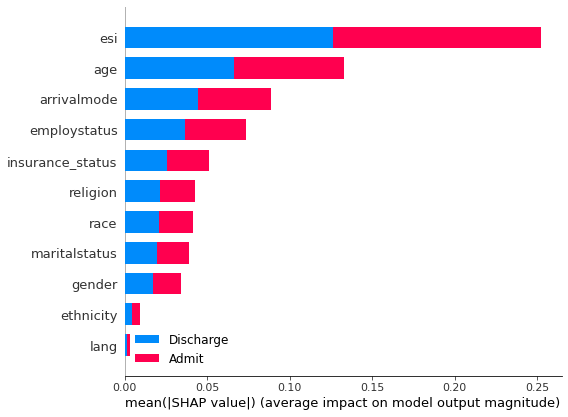

In [47]:
shap.summary_plot(
    AsianAshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

#### Asian Data

In [48]:
transformers["ethnicity"].inverse_transform([0, 1, 2, 3])

array(['Hispanic or Latino', 'Non-Hispanic', 'Patient Refused', 'Unknown'],
      dtype=object)

# Comparing the Effects of Employment Status on Hospital Triaging

In [49]:
transformers["employstatus"].inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array(['Disabled', 'Full Time', 'Not Employed', 'On Active Military Duty',
       'Part Time', 'Retired', 'Self Employed', 'Student - Full Time',
       'Student - Part Time', 'Unknown'], dtype=object)

### Comparing 'Full Time', 'Not Employed', 'Part Time', and 'Retired'

In [50]:
FullTimeData = X_test[X_test["employstatus"] == 1]
NotEmployedData = X_test[X_test["employstatus"] == 2]
PartTimeData = X_test[X_test["employstatus"] == 4]
RetiredData = X_test[X_test["employstatus"] == 5]

In [51]:
FullTimeshap_values = explainer.shap_values(FullTimeData[:500])

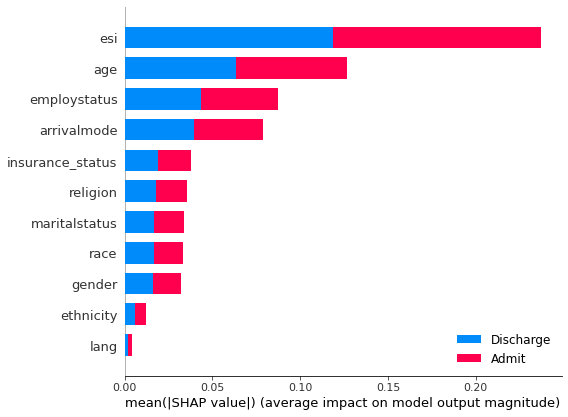

In [52]:
shap.summary_plot(
    FullTimeshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

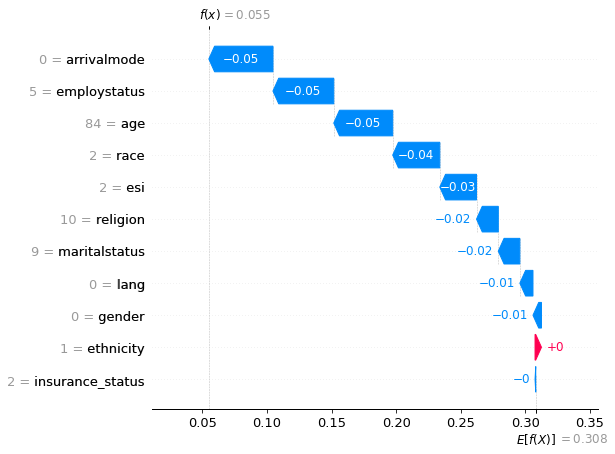

In [53]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=FullTimeshap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)

#### Full Time Data

In [54]:
Unemployedshap_values = explainer.shap_values(NotEmployedData[:500])

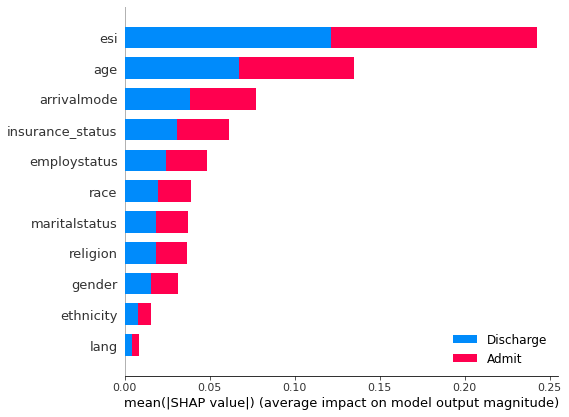

In [55]:
shap.summary_plot(
    Unemployedshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

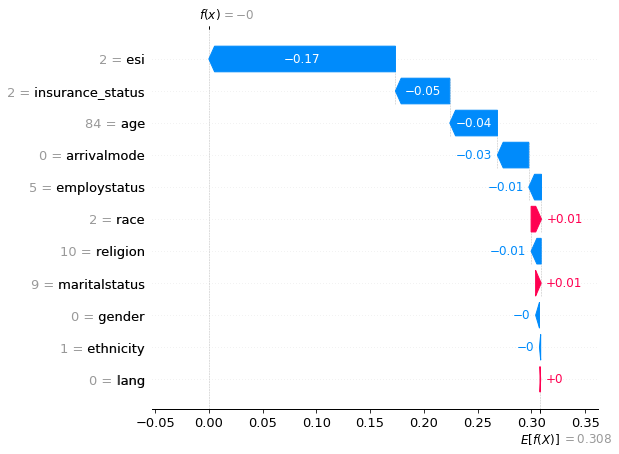

In [56]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=Unemployedshap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)

#### Unemployed Data

In [57]:
PartTimeshap_values = explainer.shap_values(PartTimeData[:500])

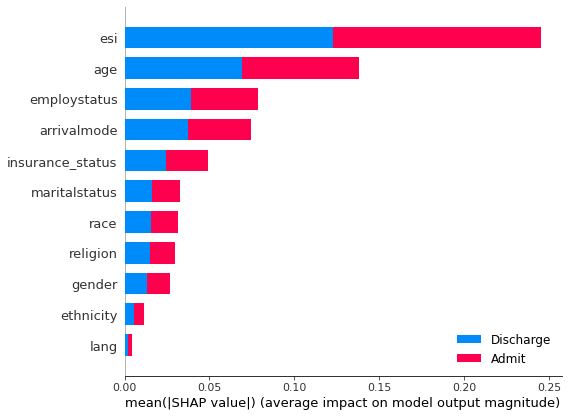

In [58]:
shap.summary_plot(
    PartTimeshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

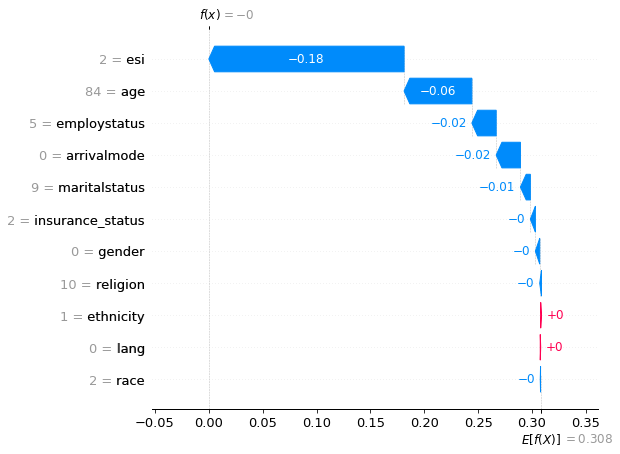

In [59]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=PartTimeshap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)

#### Part Time Data

In [60]:
Retiredshap_values = explainer.shap_values(RetiredData[:500])

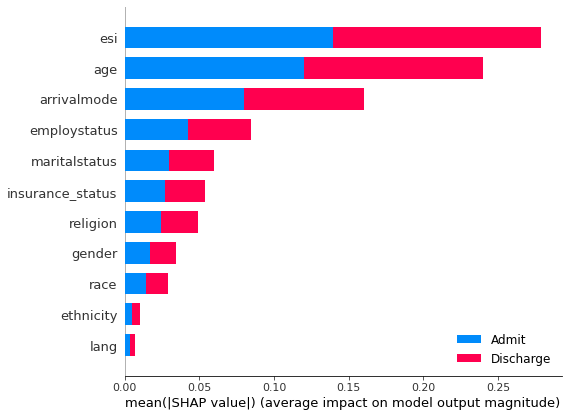

In [61]:
shap.summary_plot(
    Retiredshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

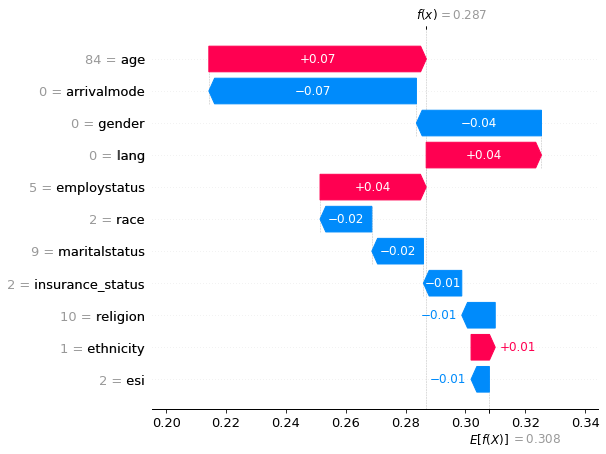

In [62]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=Retiredshap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)

#### Retired Data

# Comparing Ethnicity and its effects on Hospital Triaging

In [63]:
transformers["ethnicity"].inverse_transform([0, 1, 2, 3])

array(['Hispanic or Latino', 'Non-Hispanic', 'Patient Refused', 'Unknown'],
      dtype=object)

# Testing English Speaking on Hospital Disposition

In [64]:
transformers["lang"].inverse_transform([0, 1])

array(['English', 'Other'], dtype=object)

In [65]:
EnglishData = X_test[X_test["employstatus"] == 0]
OtherData = X_test[X_test["employstatus"] == 1]

In [66]:
Englishshap_values = explainer.shap_values(EnglishData[:500])

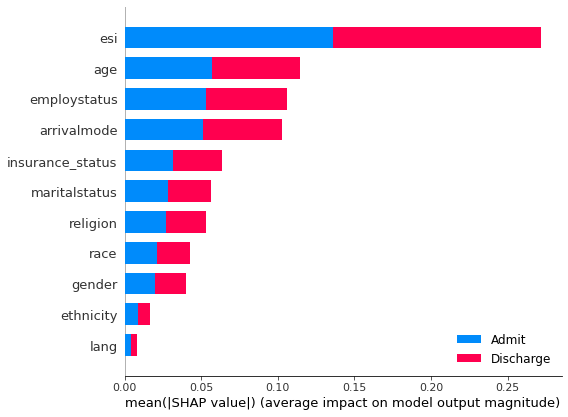

In [67]:
shap.summary_plot(
    Englishshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

In [ ]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=Englishshap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)

#### English speaking data

In [68]:
Othershap_values = explainer.shap_values(OtherData[:500])

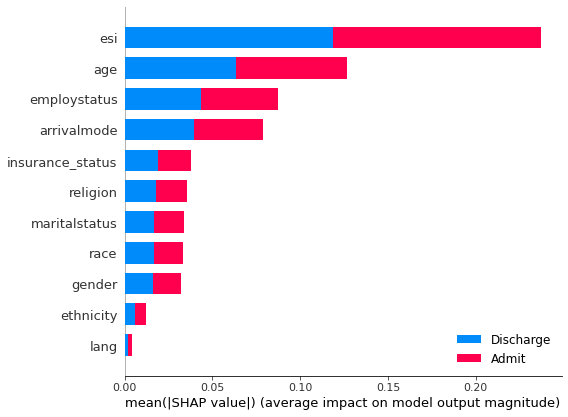

In [69]:
shap.summary_plot(
    Othershap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

In [ ]:
row = 3
shap.waterfall_plot(
    shap.Explanation(
        values=Othershap_values[0][row], 
        base_values=explainer.expected_value[0],
        data=X_test.iloc[row],
        feature_names=X_test.columns.tolist()
    ),
    max_display=X_test.shape[1]
)

#### Non English speaking

# Testing the impact of a Patient's Insurance Status on Hospital Triaging

In [70]:
transformers["insurance_status"].inverse_transform([0, 1, 2, 3, 4])

array(['Commercial', 'Medicaid', 'Medicare', 'Other', 'Self pay'],
      dtype=object)

In [71]:
MedicaidData = X_test[X_test["insurance_status"] == 1]
SelfPayData = X_test[X_test["insurance_status"] == 4]

In [72]:
Medicaidshap_values = explainer.shap_values(MedicaidData[:500])

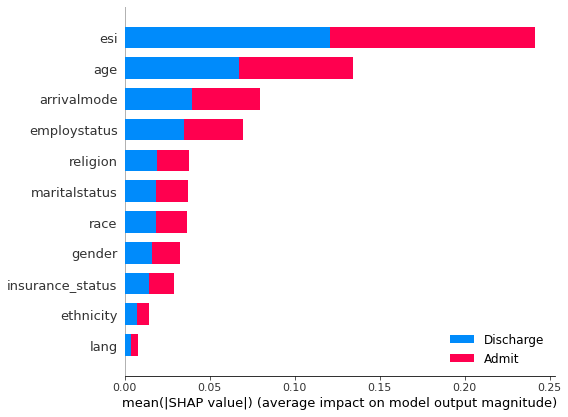

In [73]:
shap.summary_plot(
    Medicaidshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

#### Medicaid Data

In [74]:
SelfPayshap_values = explainer.shap_values(SelfPayData[:500])

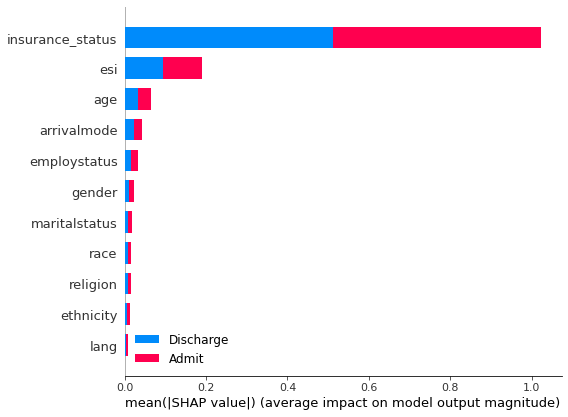

In [75]:
shap.summary_plot(
    SelfPayshap_values,
    X_test.values,
    class_names= transformers['disposition'].inverse_transform(train['disposition'].unique()),
    feature_names=X_test.columns
)

#### Self Pay Data